# Jax and advanced methods for PINNs

## Basic of Jax

Jax est une bibliothèque développée par Google pour faire du calcul intensif sur GPU/TPU différentiable. Il s'agit de **programmation fonctionnelle** et pas objet. On va donc surtout écrire des fonctions des **transformations de fonctions**.

Les fonctions sur lesquelles JAX peut opérer doivent :

- Prendre en entrée un ou plusieurs tenseurs (ou collections de tenseurs) et retourner en sortie un ou plusieurs tenseurs (ou collections de tenseurs).

- Manipuler ces tenseurs uniquement en utilisant des fonctions des bibliothèques JAX, principalement dans les modules jax.numpy et jax.scipy, et qui ont souvent un équivalent direct dans NumPy ou SciPy.

- Être **fonctionnellement pures** : exécuter la même fonction avec les mêmes entrées doit produire exactement les mêmes sorties. 

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp

# Définir une fonction simple
def f(x):
    y = jnp.sum(x**2)          # somme des carrés
    z = jnp.prod(jnp.sin(x))   # produit des sinus
    return y + z

def g(x):
    return x*x

# Créer un vecteur d'entrée
x = jnp.array([1.0, 2.0, 3.0])
y = f(x)
y2= g(x)
print(y," ",type(y))
print(y2," ",type(y2))

14.107978   <class 'jaxlib.xla_extension.ArrayImpl'>
[1. 4. 9.]   <class 'jaxlib.xla_extension.ArrayImpl'>


### Transformations in JAX

les transformations sont des "fonctions" qu'on va appliquer a nos fonctions classiques afin d'améliorer ou d'enrichir les fonctions auxquelles elles sont appliquées

les **transformations** sont composables.

La première est **vmap** qui permet de **vectoriser** des fonctions


In [2]:
import timeit
from jax import vmap
# Vecteur aléatoire
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (30000,))

# 1. Boucle explicite (lent)
start = timeit.default_timer()
y_loop = jnp.array([jnp.sin(xi**2) for xi in x])
print("Boucle :", timeit.default_timer() - start, "s")

# 2. vmap
f = lambda x: jnp.sin(x**2)
start = timeit.default_timer()
y_vmap = vmap(f)(x)
print("vmap :", timeit.default_timer() - start, "s")

# 3. Vectorisé natif (x**2)
start = timeit.default_timer()
y_vec = jnp.sin(x**2)
print("Vectorisé :", timeit.default_timer() - start, "s")

# Vérif que tout est identique
print("Différences :", jnp.max(jnp.abs(y_loop - y_vec)), jnp.max(jnp.abs(y_vmap - y_vec)))

Boucle : 1.6545652920030989 s
vmap : 0.030743584036827087 s
Vectorisé : 0.012960500025656074 s
Différences : 0.0 0.0


In [3]:
# fonction sur un point 3D
def f(point):
    x, y, z = point
    return jnp.sin(x) * jnp.cos(y) + x**2 * z + jnp.log(x + z + 1) * y

key = jax.random.PRNGKey(0)
points = jax.random.uniform(key, shape=(30000, 3))

# 1. Boucle Python
start = timeit.default_timer()
res_loop = jnp.array([f(p) for p in points])
end = timeit.default_timer()
print("Boucle Python :", end - start, "s")

# 2. vmap
f_vect = vmap(f)
start = timeit.default_timer()
res_vmap = f_vect(points)
end = timeit.default_timer()
print("vmap :", end - start, "s")

# 3. vectorisation native (opérations sur tout le tableau)
def f_native(points):
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    return jnp.sin(x) * jnp.cos(y) + x**2 * z + jnp.log(x + z + 1) * y

start = timeit.default_timer()
res_native = f_native(points)
end = timeit.default_timer()
print("Vectorisation native :", end - start, "s")

Boucle Python : 3.0503563749953173 s
vmap : 0.14128100004745647 s
Vectorisation native : 0.09318833297584206 s


Donc pour vectoriser une fonction:

```
python
f_vmap= vmap(func)
``` 

ce qui crée une fonction vectorisée qu'on appelle la nouvelle fonction comme une classique: 

```
python
f_map(x)
```

Cela s'écrit donc aussi d'un coup 

```
python
vmap(f)(points)
```

Dans **vmap** on peut choisir de vectoriser selon certaisn axes seulement un tenseur.

In [4]:
import jax.numpy as jnp
from jax import vmap

# Matrice 3x2
x = jnp.array([[1, 2],
               [3, 4],
               [5, 6]])

# Fonction à appliquer sur chaque élément d'une ligne
def f_row(row):
    return row ** 2

# Vectorisation sur l'axe 1 (colonnes)
f_vect = vmap(f_row, in_axes=1, out_axes=1)
res = f_vect(x)
print(res)


[[ 1  4]
 [ 9 16]
 [25 36]]


La transformation **jit** (Just-In-Time compilation) crée une nouvelle fonction qui est optimisée et compilée à partir de la fonction originale.

- Le premier appel peut être lent, car JAX doit compiler la fonction.
- Les appels suivants sont beaucoup plus rapides.

jit est utile quand on appelle plusieurs fois une fonction sur des données de même forme. Les tableaux peuvent changer de valeurs, mais leur taille doit rester la même.

In [5]:
from jax import jit
# Fonction simple : somme des carrés
def f(x):
    return jnp.sum(x**2)

# Version JIT
f_jit = jit(f)

# 1. Premier appel : compilation sur taille 100_000
x_compile = jnp.ones(1_000_000)
start = timeit.default_timer()
f_jit(x_compile)
end = timeit.default_timer()
print("Compilation (1_000_000) :", end - start)

# 2. Appel sur taille 500_000
x_500k = jnp.ones(500_000)
start = timeit.default_timer()
f_jit(x_500k)
end = timeit.default_timer()
print("Appel sur 500_000 :", end - start)

# 3. Appel sur taille 1_000_000
x_1M = jnp.ones(1_000_000)
start = timeit.default_timer()
f_jit(x_1M)
end = timeit.default_timer()
print("Appel sur 1_000_000 :", end - start)

Compilation (1_000_000) : 0.02638304204447195
Appel sur 500_000 : 0.029265415971167386
Appel sur 1_000_000 : 4.808296216651797e-05


In [6]:
def f(n):
    x = jnp.arange(n) ** 2
    return jnp.sum(x)

# Version JIT sans static_argnums
f_jit = jax.jit(f)

# Version JIT avec static_argnums=0
f_jit_static = jax.jit(f, static_argnums=0)

sizes = [100_000, 500_000, 1_000_000]

#print("=== Sans static_argnums ===")
#for n in sizes:
#    t = timeit.timeit(lambda: f_jit(n), number=1)
#    print(f"n={n}, time={t:.4f}s")

print("\n=== Avec static_argnums=0 ===")
for n in sizes:
    t = timeit.timeit(lambda: f_jit_static(n), number=1)
    print(f"n={n}, time={t:.8f}s")
    t = timeit.timeit(lambda: f_jit_static(n), number=1)
    print(f"n={n}, time={t:.8f}s")
    print('///////////////////')


=== Avec static_argnums=0 ===
n=100000, time=0.06752867s
n=100000, time=0.00002575s
///////////////////
n=500000, time=0.02680354s
n=500000, time=0.00001546s
///////////////////
n=1000000, time=0.02515712s
n=1000000, time=0.00002742s
///////////////////


On peut donc la composer avec une autre transformation comme **vmap**

In [7]:
# fonction sur un point 3D
def f(point):
    x, y, z = point
    return jnp.sin(x) * jnp.cos(y) + x**2 * z + jnp.log(x + z + 1) * y

key = jax.random.PRNGKey(0)
points = jax.random.uniform(key, shape=(30000, 3))

# 1. Boucle Python
start = timeit.default_timer()
res_loop = jnp.array([f(p) for p in points])
end = timeit.default_timer()
print("Boucle Python :", end - start, "s")

# 2. vmap
f_vect = jit(vmap(f))
start = timeit.default_timer()
res_vmap = f_vect(points)
end = timeit.default_timer()
print("vmap jit 1 :", end - start, "s")

start = timeit.default_timer()
res_vmap = f_vect(points)
end = timeit.default_timer()
print("vmap jit 2:", end - start, "s")

# 3. vectorisation native (opérations sur tout le tableau)
def f_native(points):
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    return jnp.sin(x) * jnp.cos(y) + x**2 * z + jnp.log(x + z + 1) * y

start = timeit.default_timer()
res_native = f_native(points)
end = timeit.default_timer()
print("Vectorisation native :", end - start, "s")

Boucle Python : 2.9679302079603076 s
vmap jit 1 : 0.020278625015635043 s
vmap jit 2: 2.779101487249136e-05 s
Vectorisation native : 0.0012481669546104968 s


La dernière famille de transformation classique ce sont les transformations de derivation
comme "grad", "hessian" qui permettent de dériver une ou plusieurs fois une fonction.

La encore ses transformations **prennent en entrée des fonctions et renvoit des fonctions**.


In [8]:
# Fonction scalaire simple
def f(x):
    return x[0]**2 + 3*x[1]**3

x = jnp.array([2.0, 1.0])

# Gradient : vecteur des dérivées partielles
grad_f = jax.grad(f)
print("Gradient :", grad_f(x))  

# Hessienne : matrice des dérivées secondes
hess_f = jax.hessian(f)
print("Hessienne :\n", hess_f(x))

Gradient : [4. 9.]
Hessienne :
 [[ 2.  0.]
 [ 0. 18.]]


### Jacobienne et modes de différentiation

La **Jacobienne** $J_f(x)$ d'une fonction vectorielle $f : \mathbb{R}^n \to \mathbb{R}^m$ est la matrice des dérivées partielles :  
$$
J_f(x) = \begin{bmatrix} \frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\ \vdots & \ddots & \vdots \\ \frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n} \end{bmatrix}
$$

En JAX, on peut la calculer avec `jax.jacobian(f)`.

#### Modes de différentiation

- **Forward mode** : efficace si $n \ll m$ (peu de variables d'entrée, beaucoup de sorties)
- **Reverse mode** : efficace si $m \ll n$ (peu de sorties, beaucoup de variables d'entrée) — c'est le mode utilisé par `jax.grad` pour les fonctions scalaires.

Le choix du mode détermine la complexité et la mémoire nécessaires pour le calcul de la Jacobienne.

Les modes forward et reverse sont accessibles: `jax.jacfwd(f)` et `jax.jacrev(f)`.

On peut aussi directement calculer les produis jacobienne vecteur forward (JVP) et reverse (VJP) avec `jax.jvp(f, (x,), (v,))` et `jax.vjp(f, (x,), (v,))`.

In [9]:
import jax
import jax.numpy as jnp

def f(x):
    return jnp.array([x[0] * x[1], x[0] + x[1]])

x = jnp.array([1.0, 2.0])
v = jnp.array([0.5, 0.5])  # direction

y, jv = jax.jvp(f, (x,), (v,))
print("f(x) =", y)
print("Jacobian-vector product =", jv)

fx,func_jvp = jax.vjp(f,x)
y2= func_jvp(v)
print("vector jacobian product =", y2)

f(x) = [2. 3.]
Jacobian-vector product = [1.5 1. ]
vector jacobian product = (Array([1.5, 1. ], dtype=float32),)


On peut évidemment combiner les transformations de dérivation et jit, vmap.

A partir du moment on on dérive il s'agit de fonction non vectorisée donc vous pourrez pas l'appliquer a tableau directement comme sinus ou $x^2$. il faut la vectoriser avec **vmap** 

In [10]:
import jax
import jax.numpy as jnp
import timeit

# Fonction scalaire
def f(x):
    return jnp.sin(x) * jnp.exp(x)

# Gradient scalaire
df = jax.grad(f)

# Version vectorisée
df_vmap = jax.vmap(df)

# Version vectorisée + compilée
df_jit = jax.jit(df_vmap)

# Gros batch de points
x = jnp.linspace(0, 10, 10_000)

# --- Mesures de temps ---

def grad_loop(x):
    return jnp.array([df(xi) for xi in x])

print("Loop :", timeit.timeit(lambda: grad_loop(x), number=1))

# vmap
print("vmap :", timeit.timeit(lambda: df_vmap(x).block_until_ready(), number=1))

# jit (premier appel inclut la compilation)
print("jit vmap (1er appel):", timeit.timeit(lambda: df_jit(x).block_until_ready(), number=1))
print("jit vmap (2ème appel):", timeit.timeit(lambda: df_jit(x).block_until_ready(), number=1))

Loop : 5.415703999984544
vmap : 0.11494141700677574
jit vmap (1er appel): 0.017729041050188243
jit vmap (2ème appel): 5.770899588242173e-05


### Example of application to numerical code

In [11]:
import timeit as it
from jax.scipy.sparse.linalg import cg

 # ---- 1D Laplacien FD ----
def build_matrix(N, L=1.0):
    """Matrice Laplacien 1D FD Dirichlet"""
    dx = L / (N + 1)
    diag = -2.0 * jnp.ones(N)
    off = jnp.ones(N - 1)
    A = jnp.diag(diag) + jnp.diag(off, 1) + jnp.diag(off, -1)
    return -A / dx**2, dx


# Fixer le maillage
N = 200
A, dx = build_matrix(N)
x = jnp.linspace(dx, 1.0 - dx, N)


# ---- Solveur ----
def solve(mu, sigma):
    """Résout -u'' = exp(-(x-mu)^2/(2 sigma^2)), avec BC Dirichlet"""
    f = jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # CG retourne (solution, info)
    u, info = cg(A, f, tol=1e-7, maxiter=500)
    return u

In [12]:
# Vectorisation
solve_vmap = jax.vmap(solve, in_axes=(0, 0))
solve_vmap_jit = jax.jit(jax.vmap(solve, in_axes=(0, 0)))
solve_jit_vmap = jax.vmap(jax.jit(solve), in_axes=(0, 0))
solve_jit_vmap_jit = jax.jit(jax.vmap(jax.jit(solve), in_axes=(0, 0)))

# ---- Comparaison temps ----
import numpy as np

# 100 couples (mu, sigma)
key = jax.random.PRNGKey(0)
mus = jax.random.uniform(key, (2000,), minval=0.2, maxval=0.8)
sigmas = 0.05 + 0.15 * jax.random.uniform(key, (2000,))


# Boucle Python
t0 = it.default_timer()
# us_loop = [solve(float(mu), float(sigma)) for mu, sigma in zip(mus, sigmas)]
# us_loop = jnp.stack(us_loop)
t1 = it.default_timer()


# vmap + jit
t2 = it.default_timer()
us_vmap = solve_vmap(mus, sigmas)
t3 = it.default_timer()

t2bis = it.default_timer()
us_vmap = solve_jit_vmap(mus, sigmas)
t3bis = it.default_timer()


t2bisbis = it.default_timer()
us_vmap = solve_jit_vmap_jit(mus, sigmas)
t3bisbis = it.default_timer()


print(f"Temps boucle Python : {t1 - t0:.8f} s")
print(f"Temps vmap : {t3 - t2:.8f} s")
print(f"Temps vmap hit unitaire: {t3bis - t2bis:.8f} s")
print(f"Temps jit vmap hit unitaire: {t3bisbis - t2bisbis:.8f} s")


Temps boucle Python : 0.00000962 s
Temps vmap : 0.48568967 s
Temps vmap hit unitaire: 0.07540054 s
Temps jit vmap hit unitaire: 0.05961092 s


### Efficient loop and control structure in Jax

- En JAX, une boucle Python classique (for) est lente car elle sort du monde JAX et fait un aller-retour avec l’interpréteur Python à chaque itération.
    
- Pour que JAX compile et optimise la boucle, il faut utiliser les structures de contrôle spécifique a jax qui sont donc optimisé et compilé.

- `scan` est l’équivalent d’une boucle `for` avec accumulation d’un état interne.  
Il est souvent utilisé pour des boucles récurrentes ou des intégrateurs temporels.

**Syntaxe :**
```python
y, state = lax.scan(f, init, xs)
```

- `white_loop` Permet d’exprimer une boucle conditionnelle while.
La condition et le corps doivent être des fonctions pures.

**Syntaxe :**
```python
result = lax.while_loop(cond_fun, body_fun, init)
```


- `fori_loop` Permet d’exprimer une boucle for.
Le le corps doivent être une fonction pure.

**Syntaxe :**
```python
result =  lax.fori_loop(start, stop, body_fun, init)
```

In [47]:
from jax import lax
xs = jnp.arange(5)  # [0,1,2,3,4]

sum = 0
ys = []
for x in xs:
    sum = sum + x
    ys.append(sum)

ys = jnp.array(ys)
final_state = sum

print(ys)          # [0,1,3,6,10]
print(final_state) # 10

def f(sum, x):
    sum = sum + x
    return sum, sum

xs = jnp.arange(5)  # [0,1,2,3,4]
ys, final_state = lax.scan(f, 0, xs)

print(ys)          # [0,1,3,6,10]
print(final_state) # 10

[ 0  1  3  6 10]
10
10
[ 0  1  3  6 10]


On doit donner a "scan" une fonction qui renvoit une variable d'accumulation et une autre qui contiendra une liste des sorties qu'on veut pour toutes les étapes.

In [48]:
import jax.numpy as jnp
from jax import lax

r = 0.1
K = 100.0

def logistic_step(N, _):
    N_next = N + r * N * (1 - N / K)
    y = N_next / K              # on stocke seulement la proportion
    return N_next, y            # carry = état complet, y = ce qu'on collecte

N0 = 10.0
timesteps = jnp.arange(10)

final_state, proportions = lax.scan(logistic_step, N0, timesteps)

print("État final =", final_state)
print("Proportions collectées =", proportions)

État final = 22.612953
Proportions collectées = [0.109      0.1187119  0.12917385 0.14042264 0.15249304 0.16541694
 0.17922235 0.19393253 0.20956479 0.22612953]


### Random Numbers

- La génération de nombres pseudo-aléatoires est nativement prise en charge dans le module numpy.random. 
- La génération de nombres pseudo-aléatoires repose sur un état global, qui peut être défini à une condition initiale déterministe en utilisant numpy.random.seed()

In [15]:
import numpy as np
np.random.seed(0)

print(np.random.random())
print(np.random.random())
print(np.random.random())
print(np.random.random())
print(np.random.random())
print(np.random.random())

0.5488135039273248
0.7151893663724195
0.6027633760716439
0.5448831829968969
0.4236547993389047
0.6458941130666561


En fixant la Seed on va fixer la série de nombre pseudo aléatoire qu'on va générer. Si on ne donne pas de seed elle est généré aléatoirement à partir de l'horloge du système.

En numpy pour générer plusieurs nombres aléatoire en même temps

In [15]:
np.random.seed(0)
print(np.random.uniform(size=3))
print(np.random.uniform(size=3))

[0.5488135  0.71518937 0.60276338]
[0.54488318 0.4236548  0.64589411]


On voit que tirer 6 fois un nombre ou 2 fois 3 nombre sont deux opérations identiques lorsque la Seed est fixé.

La génération de nombres aléatoires dans JAX est très différente car il est important que la génération de nombres pseudo-aléatoires soit : reproductible, parallélisable et vectorisable.

On va commencer par un problème de reproductibité 

In [16]:
import numpy as np

np.random.seed(0)

def f1(): return np.random.uniform()
def f2(): return np.random.uniform()

def f3(): return f1() + 2 * f2()

print(f3())

1.9791922366721637


On comprend bien que le code ne donnera pas le même résultat si f1 est appelé en premier ou f2.
En numpy c'est âs grave car l'ordre d'appel est prédéterminer et toujours le même

Pour une exécution efficace le compilateur JIT est libre de réordonner, d’élider et de fusionner différentes opérations donc la nouvelle fonction après "jit" pourrait donné un résultat différent.

Chaque fonction nécessitant des nombres aléatoires prend explicitement une **clé aléatoire** en entrée et retourne une **nouvelle clé** ainsi que le résultat afin que l’exécution reste déterministe et réordonnable, même avec le compilateur JIT ou dans des environnements multi-appareils.

In [17]:
from jax import random

key = random.key(42)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 42]


La clé sert en fait de substitut à l’objet d’état caché de NumPy. Ici elle est passé explicitement aux fonctions comme jax.random(). 
Il est important de noter que les fonctions aléatoires ne la modifient pas : fournir le même objet clé à une fonction aléatoire produira toujours le même échantillon.

In [18]:
key = random.key(42)
print(random.normal(key))
print(random.normal(key))

key = random.key(43)
print(random.normal(key))
print(random.normal(key))

-0.028304616
-0.028304616
0.07520543
0.07520543


Réutiliser la même clé, même avec différentes fonctions aléatoires peut entraîner des sorties corrélées, ce qui est généralement indésirable.

Donc il est naturel de ne jamais réutiliser les clés sauf si vous voulez des sorties identiques.

Si on veut plusieurs échantillons indépendants, il faut diviser la clé en plusieurs nouvelles clés. 
On peut faire cela avec "random.split()"

In [19]:
key = random.key(42)
key1, key2 = random.split(key)
x = random.normal(key1)
y = random.normal(key2)
print(x, y)

x1 = random.normal(key1)
y2 = random.normal(key2)
print(x1, y2)

0.07592554 0.60576403
0.07592554 0.60576403


On pourrait faire 
```
key1 = jax.random.PRNGKey(42)
key2 = jax.random.PRNGKey(43)
x = jax.random.normal(key1)
y = jax.random.normal(key2)
```

mais split est plus simple car généré un nombre important de clés. 

De plus quand tu écris une fonction qui prend une clé en entrée, tu ne veux pas avoir à inventer de nouvelles seeds arbitraires à l’intérieur. split() te permet de créer de nouvelles clés de manière systématique et sûre.

In [20]:
import jax
import jax.numpy as jnp

# Clé initiale
key = jax.random.PRNGKey(42)

# Générer 5 clés indépendantes
keys = jax.random.split(key, num=10)

# Utiliser chaque clé pour générer un échantillon aléatoire
samples = jnp.array([jax.random.normal(k) for k in keys])

print("Clés générées :\n", keys)
print("Échantillons aléatoires :\n", samples)

Clés générées :
 [[1832780943  270669613]
 [  64467757 2916123636]
 [2465931498  255383827]
 [3134548294  894150801]
 [2954079971 3276725750]
 [2765691542  824333390]
 [2768684296 3055579793]
 [2547012911 1371500959]
 [1016697191 2390192106]
 [1128875147 2463678267]]
Échantillons aléatoires :
 [ 0.07592554  0.60576403  0.4323065  -0.2818947   0.6549178  -0.2166012
 -0.25440374  0.2886397   0.14384735 -1.3462586 ]


Contrairement a Numpy echnatillonnner d'un coup trois nombre ou fait trois échantinnollage d'un nombre ne sont pas équivalent

In [21]:
key = random.key(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.key(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [0.07592554 0.60576403 0.4323065 ]
all at once:  [-0.02830462  0.46713185  0.29570296]


### Pytree

Un **pytree** est une structure de données de type arbre hierarchique définie de Jax dont les feuilles sont des objets manipulables par JAX (typiquement des jnp.ndarray, des scalaires, etc.)

- les **feuilles** sont des objets de type: jax.Array / jnp.ndarray, int, float, None qui seront les données sur lequel on fera les calculs.
- des **noeuds internes**  qui sont les structures que Jax sait parcourir comme les tuples, listes, dictionnaires, namedtuple
ou des pytrees. En pratique cela decrit comme les données sont organisés.

Quand tu veux différencier (grad) vectoriser (vmap) ou compiler une fonction (jit) avec des données complexes comme
 - paramètres de réseaux de neurones (poids, biais, hyperparamètres),
 - structures de maillage,
 - des matrices creuses,
 - mélange de scalaires, tableaux, dictionnaires…

 tu dois faire trois chose:
 - transformer ta structure complexe en un vecteur de paramètres $\theta$,
 - différentier ou vectoriser la fonction par rapport à $\theta$
 - re-construire la structure de données à partir du résultats

Les **pytrees** automatise cela.

Les transformations **jit, vmap, grad, jacfwd, jacrev**, etc. de JAX ne savent travailler que sur des objets que JAX peut représenter comme un pytree de feuilles différentiables.

In [22]:
#example de pytree
import jax
import jax.numpy as jnp 
from collections import namedtuple

x = jnp.array([1, 2, 3])
# → pytree trivial : une seule feuille, pas de structure

pytree = [jnp.array([1, 2]), jnp.array([3, 4])]
# Feuilles : deux tableaux
# Structure : list avec 2 éléments

pytree = (jnp.array([1., 2.]), 3.0, jnp.array([[1, 2], [3, 4]]))
# Feuilles : [array([1,2]), 3.0, array([[1,2],[3,4]])]
# Structure : tuple avec 3 éléments

params = {
    "layer1": {"W": jnp.ones((2, 2)), "b": jnp.zeros(2)},
    "layer2": (jnp.eye(2), 3.0)
}
# Feuilles : [layer1.W, layer1.b, layer2[0], layer2[1]]
# Structure : dict -> dict -> array/scalar + tuple


Point = namedtuple("Point", ["x", "y"])
pytree = Point(jnp.array([1.0]), jnp.array([2.0]))
# Feuilles : [x, y]
# Structure : namedtuple Point(x=*, y=*)

config = {
    "mesh": {
        "nodes": jnp.linspace(0, 1, 10),
    },
    "params": {
        "alpha": jnp.array(0.1),
        "beta": jnp.array(0.01)
    },
    "time": 0.0
}
# Feuilles : [nodes, cells, alpha, beta, time]
# Structure : dict -> dict -> arrays/scalars

**tree map**

```jax.tree.map``` est une fonction très centrale dans JAX : elle permet d’appliquer une fonction à toutes les feuilles d’un pytree sans toucher à la structure

In [23]:
import jax
import jax.numpy as jnp

tree = {
    "a": jnp.array([1., 2.]),
    "b": (jnp.array([3., 4.]), jnp.array([5., 6.])),
    "c": 7.
}

new_tree = jax.tree.map(lambda x: x * 2, tree)
print(new_tree)

{'a': Array([2., 4.], dtype=float32), 'b': (Array([6., 8.], dtype=float32), Array([10., 12.], dtype=float32)), 'c': 14.0}


On va regarder comment on calcul le gradient d'un fonction appliquée à un pytree et afficher uniquement 
la structure du pytree obtenu.

In [24]:
## exemple de differentiation de pytree

def loss_fn(config):
    nodes = config["mesh"]["nodes"]
    alpha = config["params"]["alpha"]
    beta = config["params"]["beta"]
    t = config["time"]

    # Exemple de "perte" : intégrale discrète d'une fonction dépendant des params
    u = alpha * jnp.sin(2 * jnp.pi * nodes + t) + beta * nodes**2
    return jnp.sum(u**2)

grad_fn = jax.grad(loss_fn)
grads = grad_fn(config)

print(jax.tree.map(jnp.shape, grads))
print(grads["mesh"]["nodes"])  
print(grads["params"]["alpha"]) 
print(grads["time"])  

{'mesh': {'nodes': (10,)}, 'params': {'alpha': (), 'beta': ()}, 'time': ()}
[ 0.          0.06228238  0.02247729 -0.05394261 -0.04207692  0.0360515
  0.04943056 -0.0230454  -0.05627578  0.01296639]
0.8725252
0.0019498463


On peut avoir des éléments non différentiable dans un pytree.
Par exemple si on a des entier. Il est possible de filtrer le contenu non différentiable du pytree

In [25]:
config = {
    "mesh": {
        "nodes": jnp.linspace(0, 1, 5),
        "cells": jnp.arange(4).reshape(-1, 1)  # int32 
    },
    "params": {
        "alpha": jnp.array(0.1),
        "beta": jnp.array(0.01)
    },
    "time": 0.0
}

frozen_config = jax.tree.map(
    lambda x: (
        jax.lax.stop_gradient(x.astype(jnp.float32))
        if jnp.issubdtype(jnp.asarray(x).dtype, jnp.integer)
        else x
    ),
    config
)

def loss_fn(config):
    nodes = config["mesh"]["nodes"]
    alpha = config["params"]["alpha"]
    beta = config["params"]["beta"]
    t = config["time"]

    # Exemple de "perte" : intégrale discrète d'une fonction dépendant des params
    u = alpha * jnp.sin(2 * jnp.pi * nodes + t) + beta * nodes**2
    return jnp.sum(u**2)

grad_fn = jax.grad(loss_fn)
#grads = grad_fn(config)  # Erreur : int dans le pytree
grads = grad_fn(frozen_config)

print(jax.tree.map(jnp.shape, grads))
print(grads["mesh"]["nodes"])  # None, pas différentiable
print(grads["params"]["alpha"]) # scalaire    
print(grads["time"]) # scalaire   

{'mesh': {'cells': (4, 1), 'nodes': (5,)}, 'params': {'alpha': (), 'beta': ()}, 'time': ()}
[ 0.          0.00100624 -0.00309158 -0.00283125  0.01296639]
0.39
0.0015000042


- flatten, transforme un pytree complexe en :
    - feuilles : liste plate de tous les jax.Array (ou scalaires) différentiables.
    - treedef (noeud internes) : structure qui permet de reconstruire le pytree.

- unflatten → fait l’inverse :
    - prend les feuilles + le treedef,

In [26]:
# Pytree exemple
config = {
    "mesh": {"nodes": jnp.linspace(0,1,5), "cells": jnp.arange(4)},
    "params": {"alpha": jnp.array(0.1), "beta": jnp.array(0.01)},
    "time": 0.0
}

# --- Flatten ---
leaves, treedef = jax.tree_util.tree_flatten(config)
print("Feuilles :", leaves)
print("Treedef :", treedef)
leaves = [jnp.asarray(x) for x in leaves]

flat_vector = jnp.concatenate([jnp.ravel(x) for x in leaves])
print(flat_vector)


# Rebuild le pytree
config_reconstructed = jax.tree_util.tree_unflatten(treedef, leaves)
print("Config reconstructed:", config_reconstructed)


Feuilles : [Array([0, 1, 2, 3], dtype=int32), Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32), Array(0.1, dtype=float32, weak_type=True), Array(0.01, dtype=float32, weak_type=True), 0.0]
Treedef : PyTreeDef({'mesh': {'cells': *, 'nodes': *}, 'params': {'alpha': *, 'beta': *}, 'time': *})
[0.   1.   2.   3.   0.   0.25 0.5  0.75 1.   0.1  0.01 0.  ]
Config reconstructed: {'mesh': {'cells': Array([0, 1, 2, 3], dtype=int32), 'nodes': Array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32)}, 'params': {'alpha': Array(0.1, dtype=float32, weak_type=True), 'beta': Array(0.01, dtype=float32, weak_type=True)}, 'time': Array(0., dtype=float32, weak_type=True)}


On peut recuperer uniquement les feuilles avec ```leaves = jax.tree_util.tree_leaves(config)```
ou la structure ```treedef = jax.tree_util.tree_structure(config)```

Si on définit une classe on ne peut pas a priori appliquer ```vmap```, ```grad```et ```jit``` dessus.

Pour les appliquer sur une classe, il faut specifier comment la classe peut être transformé en pytree. Une fois fait Jax sera appliquer les transformations.

Toutes les données différentiable de la classe doivent être pouvoir être représentable par un pytree ou être un pytree.

In [28]:
class Config:
    def __init__(self, nodes, cells, alpha, beta, time):
        self.nodes = nodes       # float, différentiable
        self.cells = cells       # int, constant
        self.alpha = alpha       # float, différentiable
        self.beta = beta         # float, différentiable
        self.time = time         # float, différentiable

    # Flatten → JAX verra uniquement les feuilles différentiables
    def tree_flatten(self):
        children = (self.nodes, self.alpha, self.beta, self.time)
        aux_data = {"cells": self.cells}  # non différentiable
        return children, aux_data
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        nodes, alpha, beta, time = children
        return cls(nodes, aux_data["cells"], alpha, beta, time)
    ## cls correspond a la classe elle même donc on utilise le constructeur
    
jax.tree_util.register_pytree_node_class(Config)

cfg = Config(
    nodes=jnp.linspace(0,1,5),
    cells=jnp.arange(4),
    alpha=jnp.array(0.1),
    beta=jnp.array(0.01),
    time=jnp.array(0.0)
)

def loss_fn(cfg):
    return jnp.sum(cfg.alpha * cfg.nodes**2 + cfg.beta * cfg.nodes**3 + cfg.time)

grads = jax.grad(loss_fn)(cfg)

print(grads.nodes)  # Gradient par rapport aux nodes
print(grads.cells)  # Valeur constante, non différentiable

[0.       0.051875 0.1075   0.166875 0.23    ]
[0 1 2 3]


## Neural network, Jax and equinox

On va maintenant regarder comment écrire un réseau de neurones simples en JAX

In [29]:
class MLP:
    def __init__(self, sizes, key, scale=0.01):
        """
        sizes : liste des tailles [input_dim, hidden1, ..., output_dim]
        key : PRNGKey JAX
        """
        self.sizes = sizes
        self.key = key
        self.params = self._init_params(sizes, key, scale)

    def _init_params(self, sizes, key, scale):
        """Initialise les poids et biais du MLP."""
        keys = random.split(key, len(sizes) - 1)
        params = []
        for k, (m, n) in zip(keys, zip(sizes[:-1], sizes[1:])):
            W = scale * random.normal(k, (m, n))
            b = jnp.zeros(n)
            params.append((W, b))
        return params

    def forward(self, x, params=None):
        """Propagation avant."""
        if params is None:
            params = self.params
        activ = x
        for W, b in params[:-1]:
            activ = jnp.tanh(jnp.dot(activ, W) + b)
        W, b = params[-1]
        return jnp.dot(activ, W) + b

# -----------------------
# Exemple d'utilisation
# -----------------------
if __name__ == "__main__":
    key = random.PRNGKey(0)
    sizes = [2, 8, 1]
    model = MLP(sizes, key)

f = lambda params, x: jnp.sum(model.forward(x, params)**2)
df_dtheta = jax.grad(f, argnums=0)
x = jnp.array([0.7, 1.0])
print(model.forward(x))  # évaluation du réseau
print(df_dtheta(model.params,x))  # gradient par rapport aux params

[-0.00028367]
[(Array([[ 9.6943832e-06,  8.0792106e-06, -8.1601627e-07,  1.4039992e-06,
         3.0251124e-06,  4.6802229e-06,  4.5576512e-06, -1.1801387e-06],
       [ 1.3849119e-05,  1.1541730e-05, -1.1657376e-06,  2.0057132e-06,
         4.3215891e-06,  6.6860325e-06,  6.5109302e-06, -1.6859125e-06]],      dtype=float32), Array([ 1.3849119e-05,  1.1541730e-05, -1.1657376e-06,  2.0057132e-06,
        4.3215891e-06,  6.6860325e-06,  6.5109302e-06, -1.6859125e-06],      dtype=float32)), (Array([[-1.34117417e-05],
       [ 1.43247335e-05],
       [ 1.02826634e-05],
       [ 3.89382967e-06],
       [ 1.00004927e-05],
       [-3.69602685e-06],
       [-1.27716794e-05],
       [ 1.20784932e-06]], dtype=float32), Array([-0.00056733], dtype=float32))]


En pratique on voit que l'implémentation naturel en Jax c'est
- Une fonction qui crée et renvoit les poids
- une fonction qui évalue le réseaux et prend en entrée: les inputs mais aussi les poids du réseau afin de dériver ce réseau par rapport au poids.

On retrouve bien l'écriture totalement fonctionnnelle on notre réseau est juste une fonction de $\theta$ et de $x$

Il existe une librairie appelé equinox qui permet une implémentation des réseaux plus proche de Pytorch. 
Contrairement à l'approche précédente qui traite les poids comme un vecteur qu'on balade dans le code Equinox lui utilise les **Pytree**

In [30]:
import equinox as eqx
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3 = jax.random.split(key, 3)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(2, 8, key=key1),
                       eqx.nn.Linear(8, 8, key=key2),
                       eqx.nn.Linear(8, 2, key=key3)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias
    
f = lambda params, x: model.forward(x, params)**2
df_dtheta = jax.grad(f, argnums=0)  # gradient par rapport aux params

Ici la classe ne contient que des éléments par rapport auquel on souhaite différentier mais ce n'est pas toujours le cas.

Par exemple on peut voir définir des paramètres constants (taille des couches) ou des fonctions d'activations

In [31]:

class NeuralNetwork(eqx.Module):
    layers: list
    hidden_dims: tuple  # <-- statique

    def __init__(self, key, in_dim=2, hidden_dims=(8, 8), out_dim=2):

        self.hidden_dims = hidden_dims  # statique
        keys = jax.random.split(key, len(hidden_dims) + 1)

        # Construction dynamique des couches
        dims = (in_dim,) + hidden_dims + (out_dim,)
        self.layers = []
        for i in range(len(dims) - 2):
            self.layers.append(eqx.nn.Linear(dims[i], dims[i+1], key=keys[i]))
            self.layers.append(jax.nn.relu)
        # Dernière couche linéaire sans activation
        self.layers.append(eqx.nn.Linear(dims[-2], dims[-1], key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# === Données factices ===
key = jax.random.PRNGKey(0)
x_key, y_key, model_key = jax.random.split(key, 3)
x = jax.random.normal(x_key, (100, 2))
y = jax.random.normal(y_key, (100, 2))

# === Initialisation du modèle ===
model = NeuralNetwork(model_key, in_dim=2, hidden_dims=(16, 32, 16), out_dim=2)

Pour le gradient il faut donc séparer la partie différentiable de la classe de la partie non différentiable.

In [32]:
params, static = eqx.partition(model, eqx.is_array)
# --------------------
# Fonction de perte
# --------------------
def loss(params, static, x, y):
    model = eqx.combine(params, static)
    pred_y = jax.vmap(model)(x)
    return jnp.mean((y - pred_y) ** 2)


# --------------------
# Gradient + JIT avec static_argnums
# --------------------
grad_loss = jax.jit(
    jax.grad(loss,argnums=0),  # on dérive par rapport à params
    static_argnums=1 # on gèle `static`
)

# --------------------
# Calcul du gradient
# --------------------
grads = grad_loss(params, static, x, y)
print("Shape des gradients :", jax.tree.map(lambda g: g.shape, grads))

Shape des gradients : NeuralNetwork(
  layers=[
    Linear(
      weight=(16, 2), bias=(16,), in_features=2, out_features=16, use_bias=True
    ),
    None,
    Linear(
      weight=(32, 16),
      bias=(32,),
      in_features=16,
      out_features=32,
      use_bias=True
    ),
    None,
    Linear(
      weight=(16, 32),
      bias=(16,),
      in_features=32,
      out_features=16,
      use_bias=True
    ),
    None,
    Linear(
      weight=(2, 16), bias=(2,), in_features=16, out_features=2, use_bias=True
    )
  ],
  hidden_dims=(None, None, None)
)


```params, static = eqx.partition(model, eqx.is_array)``` separe les élements de model en partie différentiable (les tableaux typiquement) et non différential

Ensuite on crée une fonction loss qui dépend des deux séparement ```loss(param,static,x,y)```
puis on applique le grad ```jax.grad(loss)```.

Par défaut le gradient porte que sur le 1er argument donc ici on dérive par rapport a params. On a spécifié ici ```argnum=0```mais pas necessaire

Pour Jit on lui précise que l'argument ```static``` est statique et donc il optimisera pas par rapport a ceux la.

Ces opérations peuvent être automatisé par equinox

In [33]:
def loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return jnp.mean((y - pred_y) ** 2)

# --------------------
# Gradient + JIT avec static_argnums
# --------------------
grad_loss = eqx.filter_jit(
    eqx.filter_grad(loss),  # on dérive par rapport à params # on gèle `static`
)

# --------------------
# Calcul du gradient
# --------------------
grads = grad_loss(model, x, y)
print("Shape des gradients :", jax.tree.map(lambda g: g.shape, grads))

Shape des gradients : NeuralNetwork(
  layers=[
    Linear(
      weight=(16, 2), bias=(16,), in_features=2, out_features=16, use_bias=True
    ),
    None,
    Linear(
      weight=(32, 16),
      bias=(32,),
      in_features=16,
      out_features=32,
      use_bias=True
    ),
    None,
    Linear(
      weight=(16, 32),
      bias=(16,),
      in_features=32,
      out_features=16,
      use_bias=True
    ),
    None,
    Linear(
      weight=(2, 16), bias=(2,), in_features=16, out_features=2, use_bias=True
    )
  ],
  hidden_dims=(None, None, None)
)


## First PINNs in Jax

In [38]:
class MLP1D(eqx.Module):
    layers: list

    def __init__(self, key, in_dim=1, hidden_dims=(16,16), out_dim=1):
        keys = jax.random.split(key, len(hidden_dims) + 1)
        dims = (in_dim,) + hidden_dims + (out_dim,)
        self.layers = []
        for i in range(len(dims) - 2):
            self.layers.append(eqx.nn.Linear(dims[i], dims[i+1], key=keys[i]))
            self.layers.append(jax.nn.tanh)
        # Dernière couche linéaire sans activation
        self.layers.append(eqx.nn.Linear(dims[-2], dims[-1], key=keys[-1]))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [40]:
class Sampler1D:
    def __init__(self, key, x_min=0.0, x_max=1.0, n_collocation=2000, n_boundary=1000):
        self.key = key
        self.x_min = x_min
        self.x_max = x_max
        self.n_collocation = n_collocation
        self.n_boundary = n_boundary

    def collocation_points(self):
        self.key, subkey = jax.random.split(self.key)
        return jax.random.uniform(subkey, (self.n_collocation,1), minval=self.x_min, maxval=self.x_max)

    def boundary_points(self):
        # Points sur le bord gauche
        left = jnp.linspace(self.x_min, self.x_min, self.n_boundary).reshape(-1,1)
        # Points sur le bord droit
        right = jnp.linspace(self.x_max, self.x_max, self.n_boundary).reshape(-1,1)
        # Concaténation
        return jnp.vstack([left, right])


In [45]:
def f(x):
    return 4 * jnp.pi**2.0 * jnp.sin(2 * jnp.pi * x)

# Loss pour un point collocation
def pinn_loss_point(model, x):
    u = lambda xi: model(xi)[0]  # scalar->scalar
    u_xx = jax.hessian(u)(x)[:, 0]
    return (u_xx + f(x)) ** 2


# Loss pour un point boundary
def boundary_loss_point(model, x):
    u = lambda xi: model(xi)[0]
    return u(x) ** 2


# Loss totale vectorisée
def pinn_loss(model, collocation, boundary):
    # vmap sur collocation
    loss_pde = jnp.mean(jax.vmap(lambda x: pinn_loss_point(model, x))(collocation))
    # vmap sur boundary
    loss_bc = jnp.mean(jax.vmap(lambda x: boundary_loss_point(model, x))(boundary))
    return loss_pde + 5 * loss_bc


def trace_pinn_loss(model, collocation, boundary):
    # vmap sur collocation
    loss_pde = jnp.mean(jax.vmap(lambda x: pinn_loss_point(model, x))(collocation))
    # vmap sur boundary
    loss_bc = jnp.mean(jax.vmap(lambda x: boundary_loss_point(model, x))(boundary))
    return loss_pde + 5 * loss_bc, loss_pde, loss_bc


# JIT
pinn_loss = eqx.filter_jit(pinn_loss)

 //// begining training //// 
Step 0: loss = 788.422485, loss_pde = 788.232239, loss_bc = 0.038047
Step 500: loss = 357.048920, loss_pde = 356.418274, loss_bc = 0.126128
Step 1000: loss = 3.413220, loss_pde = 3.390141, loss_bc = 0.004616
Step 1500: loss = 1.734974, loss_pde = 1.713346, loss_bc = 0.004326
Step 2000: loss = 0.962603, loss_pde = 0.950172, loss_bc = 0.002486
Step 2500: loss = 0.583390, loss_pde = 0.575967, loss_bc = 0.001484
Step 3000: loss = 0.370687, loss_pde = 0.366098, loss_bc = 0.000918
Step 3500: loss = 0.243433, loss_pde = 0.240524, loss_bc = 0.000582
Step 4000: loss = 0.165898, loss_pde = 0.164001, loss_bc = 0.000379
Step 4500: loss = 0.118796, loss_pde = 0.117507, loss_bc = 0.000258
Step 5000: loss = 0.090437, loss_pde = 0.089511, loss_bc = 0.000185
Step 5500: loss = 0.073590, loss_pde = 0.072881, loss_bc = 0.000142
Step 6000: loss = 0.063685, loss_pde = 0.063104, loss_bc = 0.000116
Step 6500: loss = 0.057859, loss_pde = 0.057355, loss_bc = 0.000101
Step 7000: los

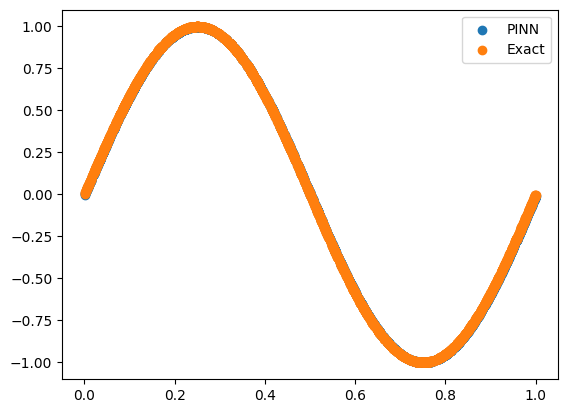

In [46]:
key = jax.random.PRNGKey(0)
model_key, sampler_key = jax.random.split(key)

# Modèle MLP
model = MLP1D(model_key)

# Sampler
sampler = Sampler1D(sampler_key)
x_collocation = sampler.collocation_points()
x_boundary = sampler.boundary_points()

# -------------------------------
# Gradient + JIT avec Equinox
# -------------------------------
grad_fn = eqx.filter_grad(pinn_loss)
grad_fn = eqx.filter_jit(grad_fn)

# -------------------------------
# Optimisation simple
# -------------------------------
import matplotlib.pyplot as plt


print(" //// begining training //// ")
lr = 2.8e-4
for step in range(10000):
    grads = grad_fn(model, x_collocation, x_boundary)
    model = eqx.apply_updates(model, jax.tree.map(lambda g: -lr * g, grads))
    if step % 500 == 0:
        loss, loss_pde, loss_bc = trace_pinn_loss(model, x_collocation, x_boundary)
        print(
            f"Step {step}: loss = {loss:.6f}, loss_pde = {loss_pde:.6f}, loss_bc = {loss_bc:.6f}"
        )

# -------------------------------
# Évaluation
# -------------------------------

x_test = sampler.collocation_points()
u_pred = jax.vmap(lambda x: model(x))(x_test)  # (1000,1,1)
u_pred = u_pred[:, 0]  # aplatisse en (1000,)
plt.scatter(x_test[:, 0], u_pred, label="PINN")
plt.scatter(x_test[:, 0], jnp.sin(2.0 * jnp.pi * x_test[:, 0]), label="Exact")
plt.legend()
plt.show()